In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

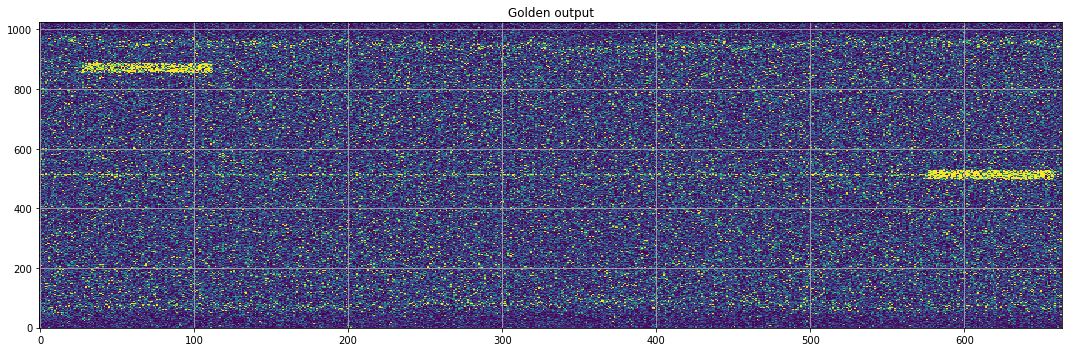

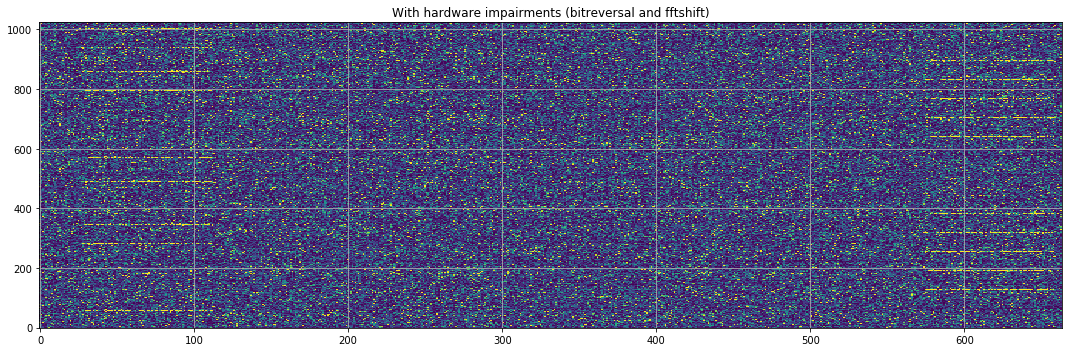

In [3]:
from pyhacores.utils import *
from scipy import signal
fft_size = 1024
avg_freq_axis = 1
file = '/home/gaspar/git/pyhacores/data/low_power_ph3.raw'
orig_inp = load_iq(file)[2120000:2800000]
# orig_inp = load_iq(file)[2120000:2130000]

orig_inp -= np.mean(orig_inp)
# orig_inp = orig_inp[:len(orig_inp)//8]

_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_size, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_size//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // avg_freq_axis)
golden_output = np.average(x, axis=1)

plt.title('Golden output')
imshow(golden_output)

plt.title('With hardware impairments (bitreversal and fftshift)')
from pyhacores.fft.util import toggle_bit_reverse

input_signal = np.roll(spectro_out, -fft_size//2, axis=0) #fftshift
input_signal = toggle_bit_reverse(input_signal.T).T
imshow(input_signal)

## Fix bitreversal and fftshift

In [4]:
from pyhacores.fft import BitreversalFFTshiftAVGPool
from pyhacores.fft.packager import DataIndexValid, unpackage, package
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=2, avg_time_axis=1)
fft_sims = simulate(dut, input_signal.T, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 680961/680961 [00:25<00:00, 26762.36it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!


In [5]:
snr(fft_sims['MODEL'], fft_sims['PYHA'])

85.70665831831049

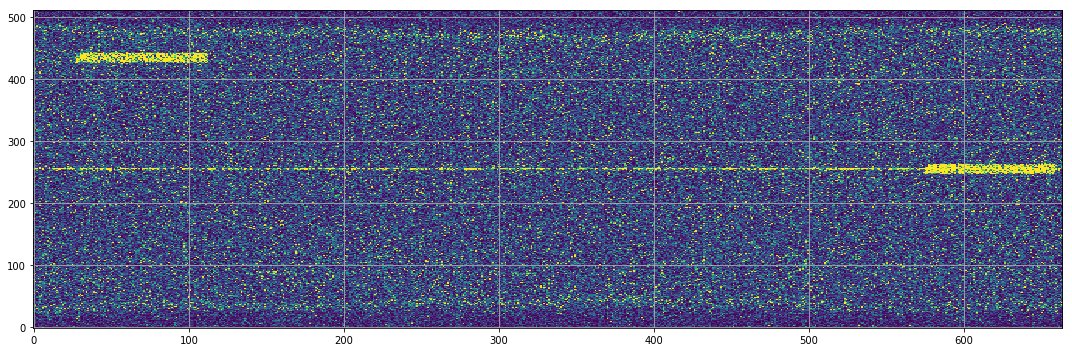

In [6]:
imshow(fft_sims['MODEL'].T)

# Use `avg_freq_axis` to compress freq axis

In [7]:
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=8, avg_time_axis=1)
fft_sims = simulate(dut, input_signal.T, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 680961/680961 [00:22<00:00, 30283.24it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!


SNR: 73.68


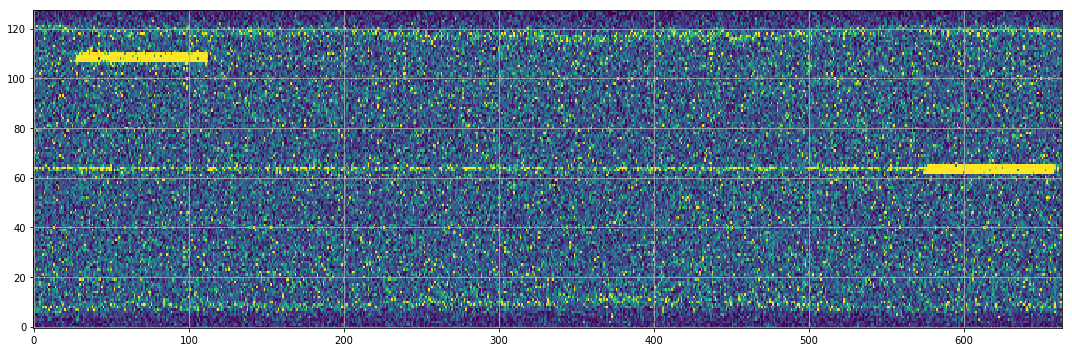

In [8]:
print(f"SNR: {snr(fft_sims['MODEL'], fft_sims['PYHA']):.2f}")
imshow(fft_sims['PYHA'].T)

## Use `avg_time_axis` to compress time axis

In [9]:
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=1, avg_time_axis=8)
fft_sims = simulate(dut, input_signal.T, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 680961/680961 [00:22<00:00, 29898.40it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!


SNR: 73.68


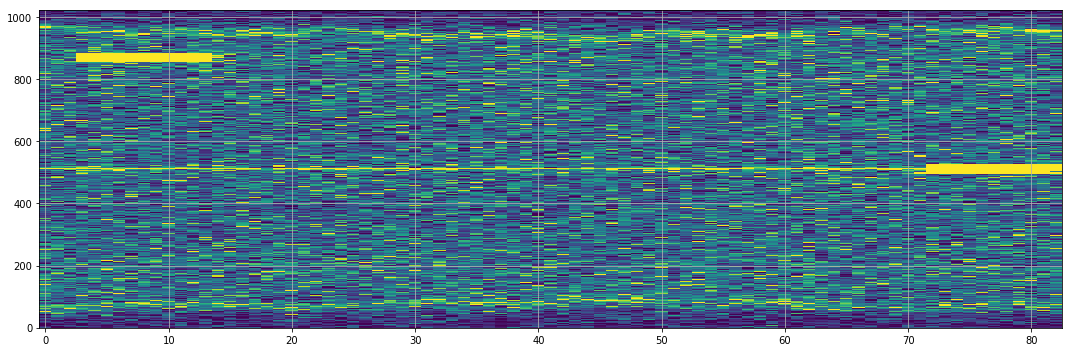

In [10]:
print(f"SNR: {snr(fft_sims['MODEL'], fft_sims['PYHA']):.2f}")
imshow(fft_sims['PYHA'].T)

# Limitations

## Uses `fullprecision` fixed-point

In [11]:
print(f'Minimum number representabe: {2**-35}')

Minimum number representabe: 2.9103830456733704e-11


## Average pooling cannot be turned off i.e. setting `avg_freq_axis=1, avg_time_axis=1`
For this case the implementation could be simplified i.e. no need for high-precision fixed-point and read-modify-write.

# Synthesis
`avg_freq_axis` controls the memory usage and decimates the output data rate.

`avg_time_axis` decimates output data rate but has ~no effect on resource usage.

## `avg_freq_axis=1` and `avg_time_axis=2`

In [12]:
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=1, avg_time_axis=2)
sims = simulate(dut, input_signal.T[:2], simulations=['MODEL', 'PYHA', 'RTL', 'GATE'])

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 3073/3073 [00:00<00:00, 3762.82it/s]

INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataIndexValid to VHDL ...


INFO:conversion:RAM to VHDL ...
INFO:conversion:BitreversalFFTshiftAVGPool to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataIndexValid to VHDL ...
INFO:conversion:RAM to VHDL ...
INFO:conversion:BitreversalFFTshiftAVGPool to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 17 12:33:13 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 369
INFO:sim:    Total combinational functions : 337
INFO:sim:    Dedicated logic registers : 178
INFO:sim:Total registers : 178
INFO:sim:Total pins : 140
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 73,728
INFO:sim:Embedded Multiplier 9-bit elements : 0
INFO:sim:Total PLLs : 0
INFO:sim:Run

In [13]:
assert sims_close(sims, rtol=1e-10, atol=1e-10)

INFO:sim:sims_close(rtol=1e-10, atol=1e-10)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!
INFO:sim:RTL OK!
INFO:sim:GATE OK!


In [14]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

Logic elements: 369
Memory: 73728
Multipler (18bit): 0


## `avg_freq_axis=4` and `avg_time_axis=1`

In [15]:
# NBVAL_IGNORE_OUTPUT
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=4, avg_time_axis=1)
sims = simulate(dut, input_signal.T[:2], simulations=['MODEL', 'PYHA', 'RTL', 'GATE'])

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 3073/3073 [00:00<00:00, 4539.90it/s]

INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...


INFO:conversion:DataIndexValid to VHDL ...
INFO:conversion:RAM to VHDL ...
INFO:conversion:BitreversalFFTshiftAVGPool to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataIndexValid to VHDL ...
INFO:conversion:RAM to VHDL ...
INFO:conversion:BitreversalFFTshiftAVGPool to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 17 12:34:06 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 352
INFO:sim:    Total combinational functions : 320
INFO:sim:    Dedicated logic registers : 170
INFO:sim:Total registers : 170
INFO:sim:Total pins : 140
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 18,432
INFO:sim:Embedded Multiplier 9-bit elemen

In [16]:
assert sims_close(sims, rtol=1e-9, atol=1e-9)

INFO:sim:sims_close(rtol=1e-09, atol=1e-09)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!
INFO:sim:RTL OK!
INFO:sim:GATE OK!


In [17]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

Logic elements: 352
Memory: 18432
Multipler (18bit): 0
